In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [4]:
mnist = fetch_openml("mnist_784", version=1)

/home/akaabdullahmateen/miniforge3/envs/gpu/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
X, y = mnist["data"].values, mnist["target"].values
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (70000, 784)
y.shape: (70000,)


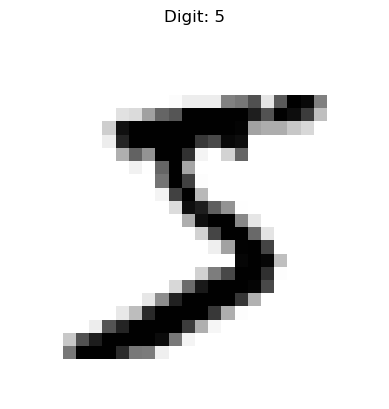

In [6]:
some_digit = X[0]
some_digit_label = y[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.title(f"Digit: {int(some_digit_label)}")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000].astype(int), y[60_000:].astype(int)

In [8]:
rng = np.random.default_rng(seed=42)
shuffle_index = rng.permutation(60_000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

## Accuracy

In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96005, 0.96585, 0.966  ])

In [13]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9091 , 0.90685, 0.913  ])

## Confusion Matrix

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.4s finished


In [65]:
confusion_matrix(y_train_5, y_train_pred)

array([[53501,  1078],
       [ 1084,  4337]])

In [67]:
precision_score(y_train_5, y_train_pred)

0.8009233610341644

In [68]:
recall_score(y_train_5, y_train_pred)

0.8000368935620734

In [70]:
f1_score(y_train_5, y_train_pred)

0.8004798818752308

## Precision-Recall Tradeoff

In [71]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3359.36856996])

In [73]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [74]:
threshold = 200_000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [75]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, verbose=3, method="decision_function")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.2s finished


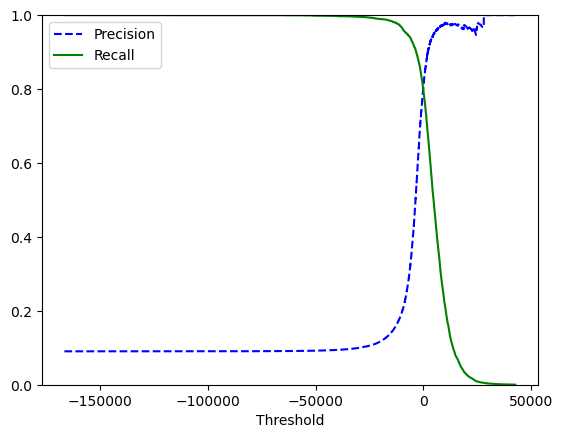

In [77]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [78]:
target_precision = 0.90
best_threshold = 0

for i, precision in enumerate(precisions):
    if precision >= target_precision:
        best_threshold = thresholds[i]
        break

best_threshold

2112.50056135196

In [79]:
y_train_pred_90 = (y_scores > best_threshold)

In [80]:
precision_score(y_train_5, y_train_pred_90)

0.900146484375

In [81]:
recall_score(y_train_5, y_train_pred_90)

0.6801328168234643

## ROC Curve

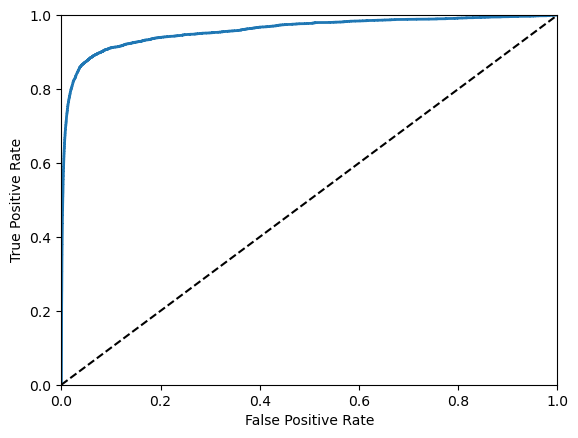

In [84]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()

In [85]:
roc_auc_score(y_train_5, y_scores)

0.9588353891004884

In [88]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, verbose=3, method="predict_proba")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [89]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

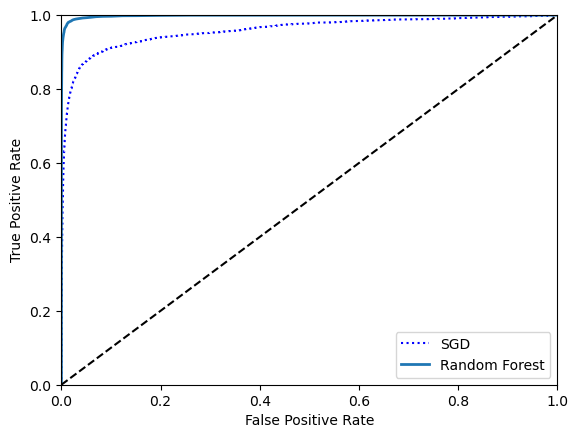

In [91]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [92]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984169191459765

In [96]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, verbose=4, method="predict")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   59.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   59.6s finished


In [97]:
precision_score(y_train_5, y_pred_forest)

0.9900822958430049

In [98]:
recall_score(y_train_5, y_pred_forest)

0.8655229662423907

## Multiclass Classification

In [15]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5])

In [16]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-13255.26534727, -26342.79430812, -16123.18564112,
         -1625.21066096, -24788.83012059,   2037.48007197,
        -20035.32310267, -12015.32415823, -10435.16795119,
         -9695.95606111]])

In [18]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5

In [21]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5])

In [22]:
len(ovo_clf.estimators_)

45

In [23]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, verbose=3, scoring="accuracy")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.875) total time=  57.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.6s remaining:    0.0s


[CV] END ................................ score: (test=0.865) total time=  57.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] END ................................ score: (test=0.869) total time= 1.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min finished


array([0.8755, 0.865 , 0.8691])

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, verbose=3, scoring="accuracy")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/akaabdullahmateen/miniforge3/envs/gpu/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] END ................................ score: (test=0.906) total time= 2.7min
[CV] END ................................ score: (test=0.905) total time= 2.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s


[CV] END ................................ score: (test=0.902) total time= 2.7min


/home/akaabdullahmateen/miniforge3/envs/gpu/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.1min finished


array([0.9057 , 0.90515, 0.9019 ])

## Error Analysis

In [26]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, verbose=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/akaabdullahmateen/miniforge3/envs/gpu/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s
/home/akaabdullahmateen/miniforge3/envs/gpu/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min finished


array([[5610,    0,   18,    8,    9,   47,   33,    4,  193,    1],
       [   1, 6418,   42,   21,    3,   48,    4,   10,  182,   13],
       [  28,   29, 5256,   88,   70,   28,   72,   41,  336,   10],
       [  25,   19,  114, 5292,    0,  201,   25,   43,  344,   68],
       [  11,   13,   45,   12, 5265,    9,   41,   18,  280,  148],
       [  33,   17,   26,  175,   53, 4512,   75,   19,  447,   64],
       [  34,   19,   43,    3,   38,   94, 5565,    6,  116,    0],
       [  18,   13,   54,   29,   53,   14,    5, 5732,  139,  208],
       [  17,   64,   41,   93,    1,  129,   32,   11, 5418,   45],
       [  26,   22,   26,   55,  125,   42,    1,  171,  294, 5187]])

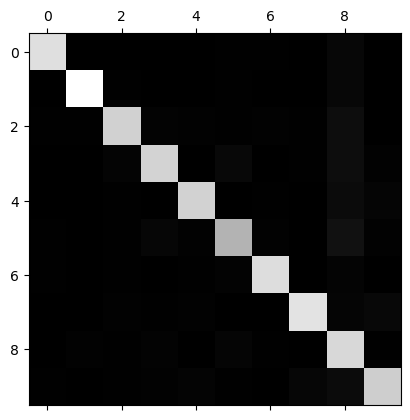

In [27]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [28]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

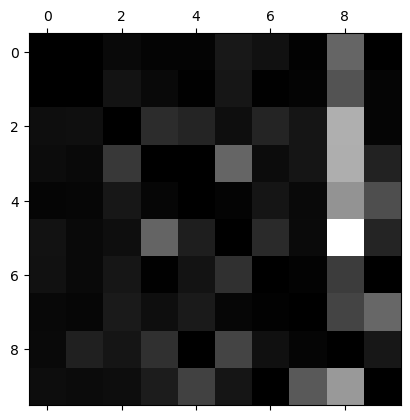

In [32]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [33]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

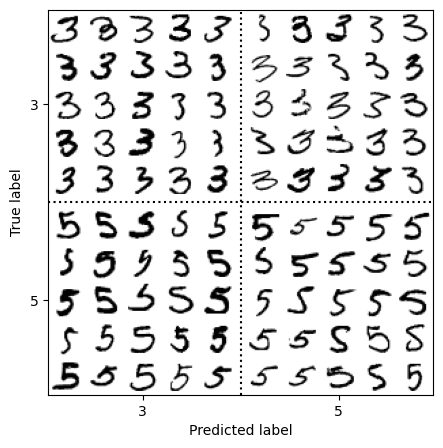

In [34]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Multilabel Classification

In [37]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [38]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [39]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3, verbose=3)
f1_score(y_train, y_train_knn_pred, average="macro")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.7s finished


0.9685256744713721

## Multioutput Classification

In [43]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [44]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

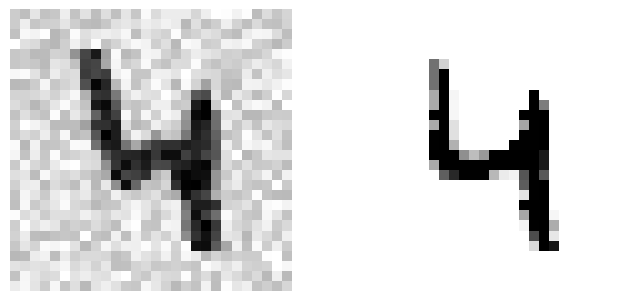

In [47]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_index = 784
noisy_digit = X_test_mod[some_index]
clean_digit = knn_clf.predict([noisy_digit])

plt.figure(figsize=(8,4))
plt.subplot(121); plot_digit(noisy_digit)
plt.subplot(122); plot_digit(clean_digit)
plt.show()